# NBA Player Performance Analysis Pipeline
## Complete demonstration of data cleaning, EDA, feature engineering, and hypothesis testing

In [2]:
# =============================================================================
# Setup and Imports
# =============================================================================

import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent / "nba_analytics"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Setup modules and styling
from data_cleaner import quick_clean_nba_data
from feature_engineer import create_feature_engineering_pipeline, validate_features_for_hypothesis_testing
from hypothesis_tester import NBAHypothesisTester, generate_hypothesis_report
from eda import create_nba_eda_analyzer, validate_for_modeling
from position_filler import (
    load_parquet_to_dataframe,
    complete_position_filling_pipeline
)

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_theme(style="whitegrid", palette="husl")
np.random.seed(111)

In [3]:
# ===================================================================
# Fill Player Positions and Save as Parquet
# ===================================================================
import sys
import os
from pathlib import Path
sys.path.append(str(Path().resolve().parent / "nba_analytics"))
import pandas as pd

# Load player game stats and player info
df_player_stats = pd.read_parquet("../data/raw/player_game_stats_seasons_2021_2022_2023_2024_2025.parquet")
df_players = pd.read_parquet("../data/raw/all_players_data_sdk.parquet")

print(f"Loaded player stats shape: {df_player_stats.shape}")
print(f"Loaded player master data shape: {df_players.shape}")


# Run the full position-filling pipeline
df_player_stats_filled, summary = complete_position_filling_pipeline(
    df_player_stats,
    df_players,
    use_manual_corrections=True
)

print("\nPipeline summary:")
for k, v in summary.items():
    print(f"{k}: {v}")

df_player_stats_filled.to_parquet("../data/processed/player_game_stats_seasons_2021_2022_2023_2024_2025_positions_filled.parquet", index=False)
print(f"\nSaved updated player stats with filled positions to:")

Loaded player stats shape: (169851, 34)
Loaded player master data shape: (5375, 18)
=== NBA POSITION FILLING PIPELINE ===
Starting with 2,091 empty positions

=== Name Matching Position Fill ===
Filled 335 positions using name matching
=== Final Position Fill Using Height Estimation ===
Players needing height-based position estimation: 19

Height-based position estimates:
Player Name | Height | Inches | Estimated Position
----------------------------------------------------------------------
Joe Johnson                    | 6-7    | 79     | F
Scotty Hopson                  | 6-7    | 79     | F
Thanasis Antetokounmpo         | 6-7    | 79     | F
Danuel House Jr.               | 6-6    | 78     | G-F
Gary Payton II                 | 6-2    | 74     | G
Kobi Simmons                   | 6-5    | 77     | G-F
Derrick Walton Jr.             | 6-1    | 73     | G
Brandon Goodwin                | 6-0    | 72     | G
Haywood Highsmith              | 6-5    | 77     | G-F
Emanuel Terry       

In [4]:
# =============================================================================
# Load Raw Data
# =============================================================================

data_path = "../data/processed/player_game_stats_seasons_2021_2022_2023_2024_2025_positions_filled.parquet"

try:
    df_raw = pd.read_parquet(data_path)
    print(f"Successfully loaded data from {data_path}")
    print(f"Dataset shape: {df_raw.shape}")
    print(f"Date range: {df_raw['game_date'].min()} to {df_raw['game_date'].max()}")
except FileNotFoundError:
    raise FileNotFoundError(f"Could not find data file at {data_path}")

Successfully loaded data from ../data/processed/player_game_stats_seasons_2021_2022_2023_2024_2025_positions_filled.parquet
Dataset shape: (169851, 34)
Date range: 2021-10-19 to 2025-06-11


In [5]:
# =============================================================================
# Data Quality Assessment
# =============================================================================

missing_summary = df_raw.isnull().sum()

missing_pct = (missing_summary / len(df_raw) * 100).round(2)

significant_missing = missing_pct[missing_pct > 0]

if len(significant_missing) > 0:
    for col, pct in significant_missing.items():
        print(f"{col}: {missing_summary[col]} ({pct}%) missing")
else:
    print("No missing values found")

fg_pct: 233 (0.14%) missing
fg3_pct: 5961 (3.51%) missing
ft_pct: 14324 (8.43%) missing


INFO:data_cleaner:Fitting NBA Data Cleaning Pipeline...
INFO:data_cleaner:Initial dataset shape: (169851, 34)


Quick NBA Data Cleaning (Level: STANDARD)


INFO:data_cleaner:Converting data types...
INFO:data_cleaner:Converting minutes to decimal format...
INFO:data_cleaner:Handling missing values...
INFO:data_cleaner:Missing values summary:
INFO:data_cleaner:  fg3_pct: 5961 (3.51%)
INFO:data_cleaner:  ft_pct: 14324 (8.43%)
INFO:data_cleaner:Performing data validation...
INFO:data_cleaner:Validation issues found:
INFO:data_cleaner:  - Found 99 records with invalid fg_pct values
INFO:data_cleaner:  - Found 61 records with invalid fg3_pct values
INFO:data_cleaner:  - Found 73 records with invalid ft_pct values
INFO:data_cleaner:  - Found 1 records with extreme reb values (>30)
INFO:data_cleaner:Detecting outliers using iqr method...
INFO:data_cleaner:Outlier detection summary:
INFO:data_cleaner:  pts: 102 outliers detected
INFO:data_cleaner:  reb: 653 outliers detected
INFO:data_cleaner:  ast: 4102 outliers detected
INFO:data_cleaner:  minutes_played: 0 outliers detected
INFO:data_cleaner:  fga: 15 outliers detected
INFO:data_cleaner:  fg3a


Cleaning Complete!
   Shape: (169851, 34) -> (169851, 42)
   Rows removed: 0
   Missing values: 20,518 -> 0


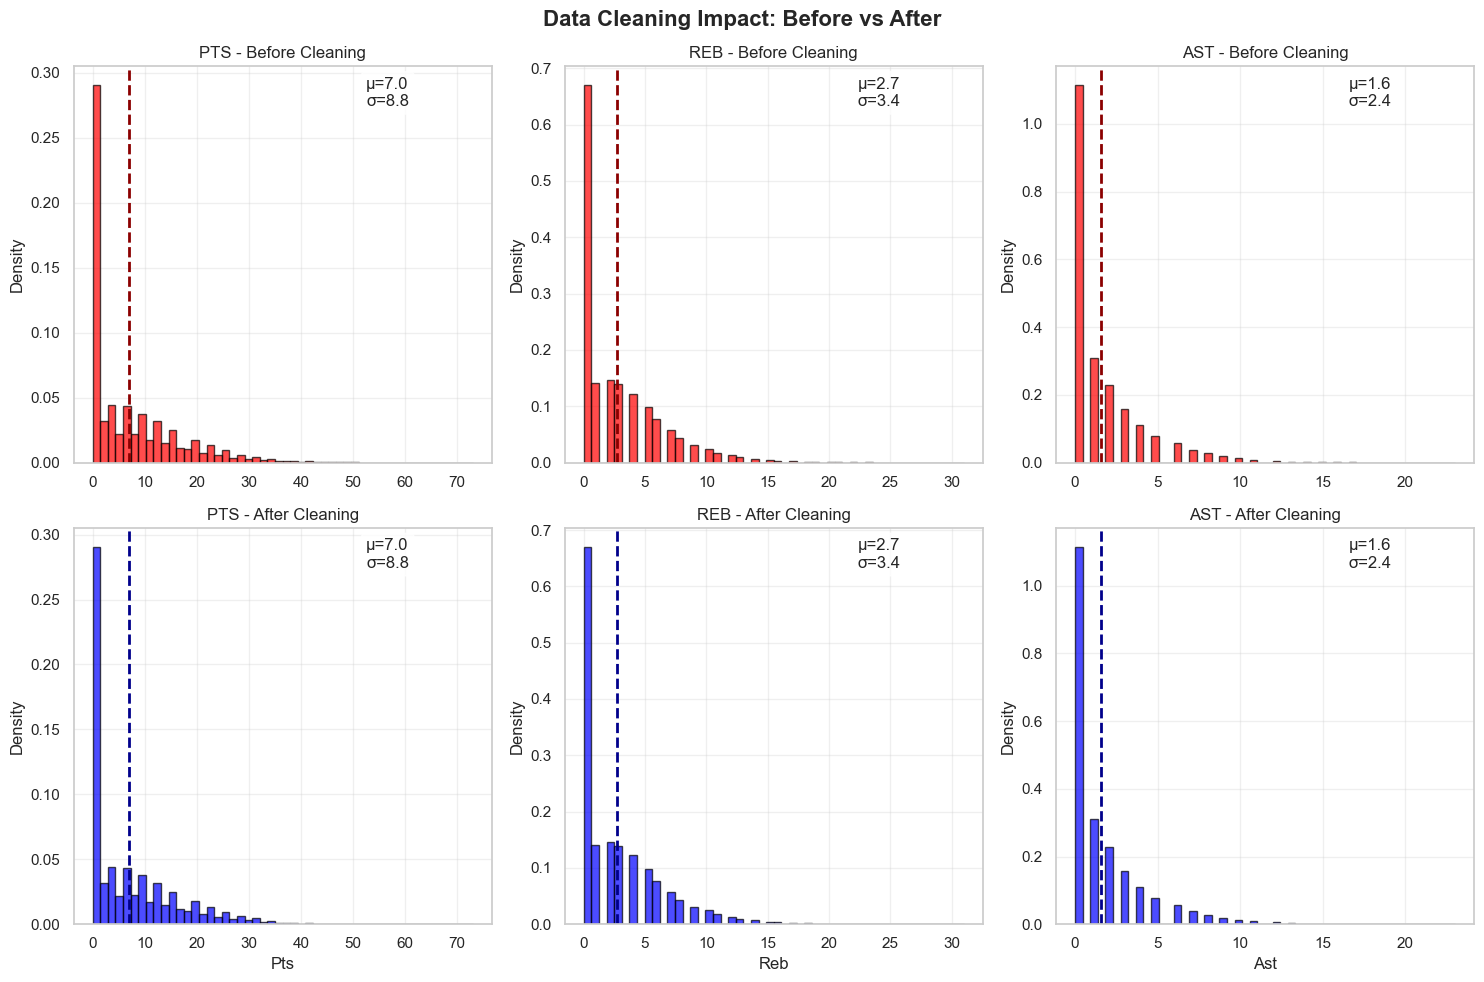

INFO:data_cleaner:Cleaning report saved to: ../data/processed/cleaned_nba_data_cleaning_report.json
INFO:data_cleaner:Cleaned data saved to: ../data/processed/cleaned_nba_data.parquet


Data saved to: ../data/processed/cleaned_nba_data.parquet
Data validation passed!
Original shape: (169851, 34) -> Cleaned shape: (169851, 42)


In [6]:
# =============================================================================
# Data Cleaning
# =============================================================================

df_cleaned, cleaning_report = quick_clean_nba_data(
    df_raw,
    cleaning_level="standard",
    save_path="../data/processed/cleaned_nba_data.parquet",
    show_plots=True
)

print(f"Original shape: {cleaning_report['original_shape']} -> Cleaned shape: {cleaning_report['cleaned_shape']}")

INFO:eda:Starting comprehensive NBA EDA analysis pipeline...
INFO:eda:Dataset dimensions: 169851 rows x 42 columns
INFO:eda:Executing data_quality analysis...
INFO:eda:Performing comprehensive data quality analysis...
INFO:eda:Executing target_variables analysis...
INFO:eda:Analyzing target variable distributions and characteristics...
INFO:eda:Executing correlation analysis...
INFO:eda:Performing correlation analysis for feature relationships...
INFO:eda:Executing outliers analysis...
INFO:eda:Detecting statistical outliers in target variables...
INFO:eda:Creating analysis visualizations...
INFO:eda:Visualization saved: ../outputs/visuals/EDA/target_distributions.png
INFO:eda:Visualization saved: ../outputs/visuals/EDA/correlation_matrix.png
INFO:eda:Visualization saved: ../outputs/visuals/EDA/missing_data.png
INFO:eda:Visualization saved: ../outputs/visuals/EDA/outlier_analysis.png
INFO:eda:Analysis report saved: ../outputs/reports/eda_analysis_report.txt
INFO:eda:EDA analysis pipeli

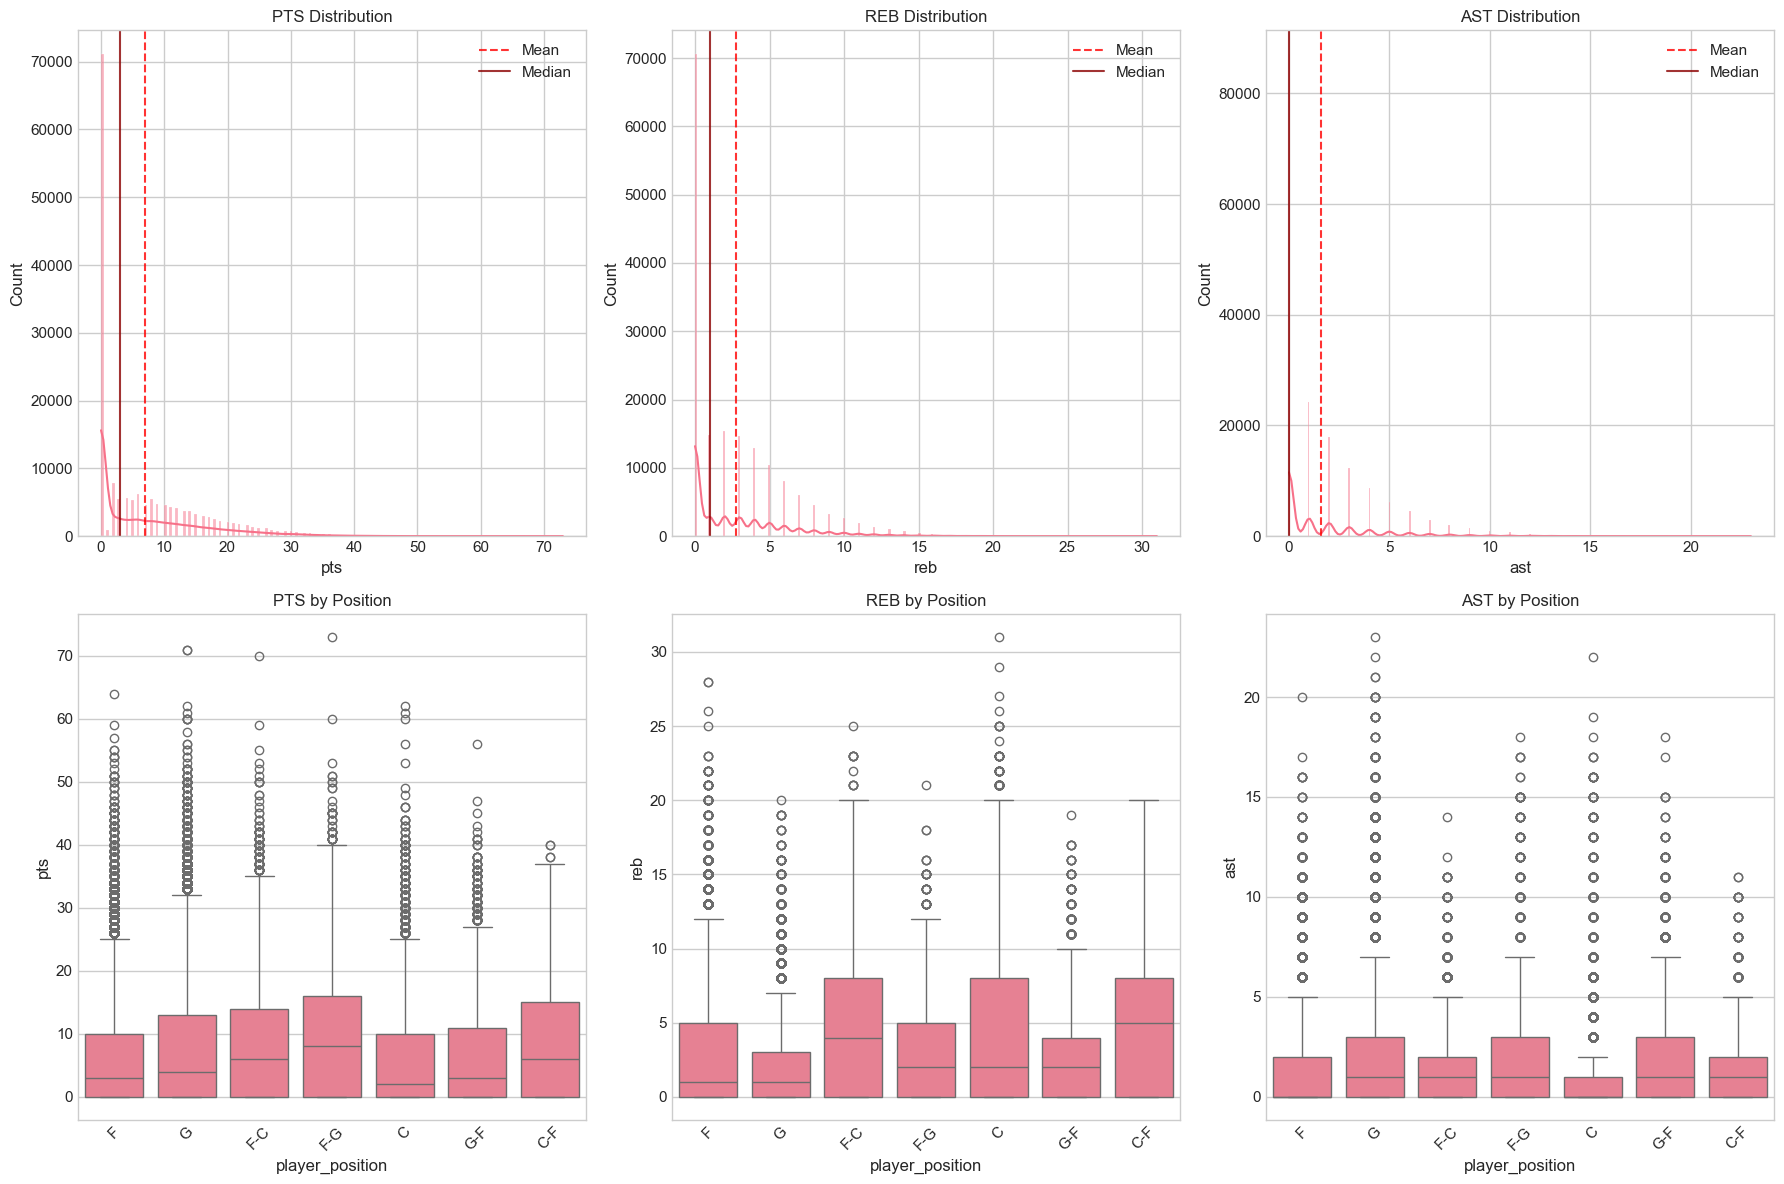

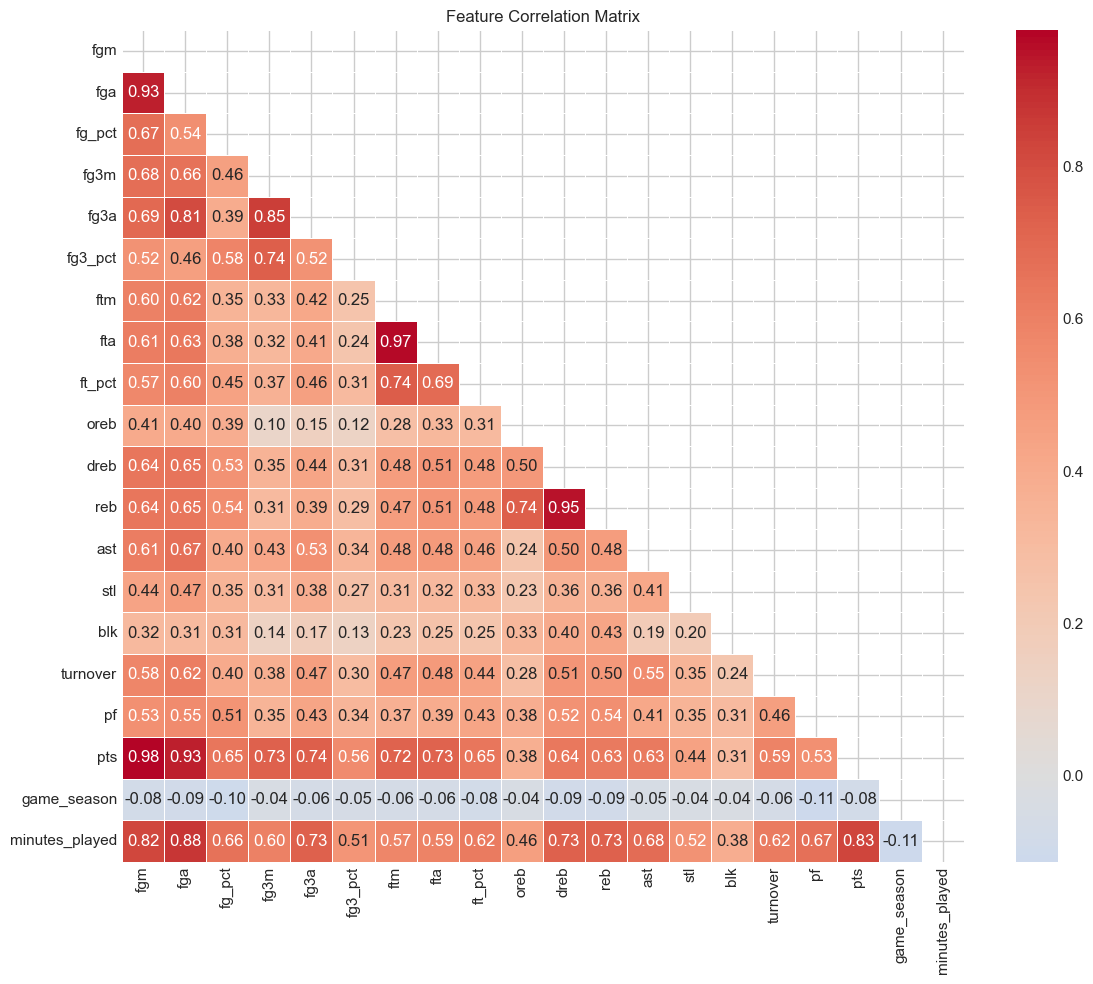

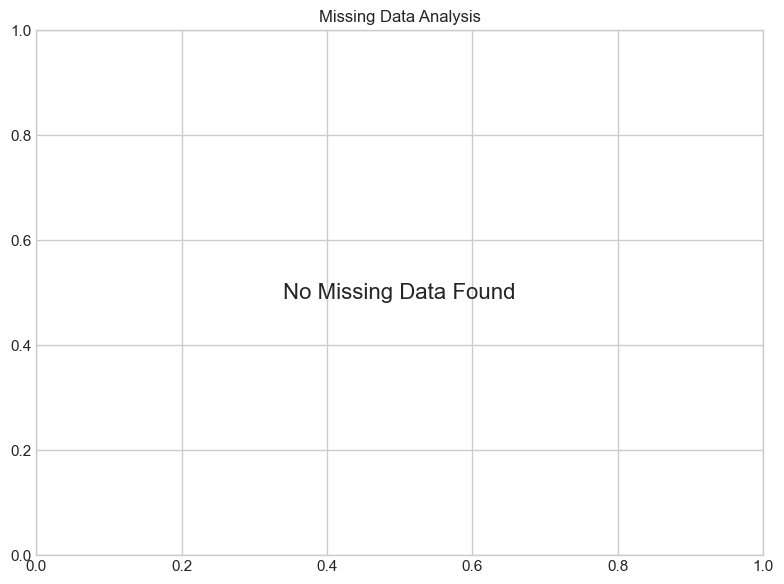

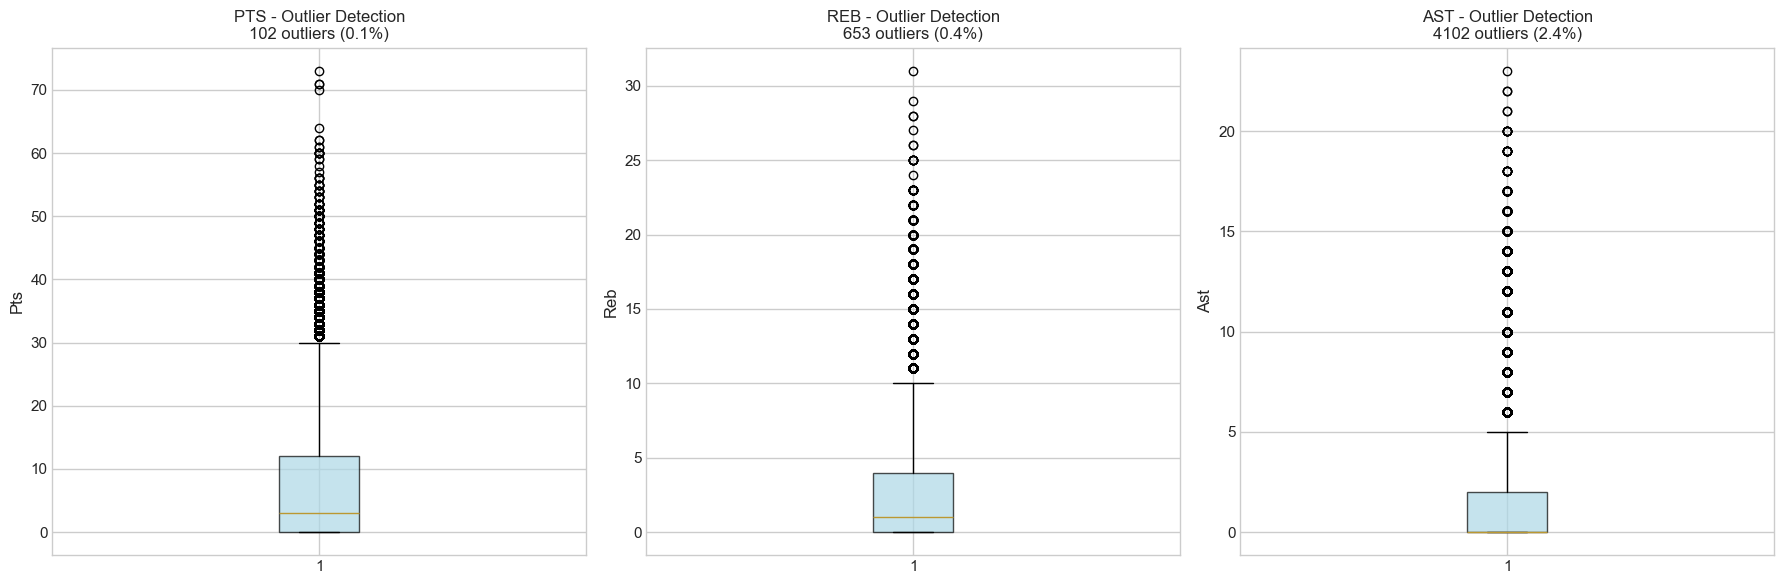

In [7]:
# =============================================================================
# Exploratory Data Analysis (EDA)
# =============================================================================

eda_analyzer = create_nba_eda_analyzer(
    target_variables=['pts', 'reb', 'ast'],
    correlation_threshold=0.8,
    viz_dir="../outputs/visuals/EDA"
)

eda_results = eda_analyzer.run_complete_eda(
    df_cleaned,
    save_plots=True,
    save_report=True
)

In [8]:
# =============================================================================
# Feature Engineering
# =============================================================================

feature_pipeline = create_feature_engineering_pipeline({
    'include_rest_days': True,
    'include_shooting_efficiency': True,
    'include_per_minute_rates': True,
    'include_game_context': True,
    'include_performance_milestones': True
})

df_engineered = feature_pipeline.fit_transform(df_cleaned)

INFO:feature_engineer:Fitting Enhanced NBA Feature Engineering Pipeline...
INFO:feature_engineer:Calculating rest days between games...
INFO:feature_engineer:Rest days distribution (top 10):
rest_days
0.0        13
1.0     26878
2.0    104373
3.0     25729
4.0      4888
5.0      1287
6.0       810
7.0      1491
8.0      1530
9.0       556
Name: count, dtype: int64
INFO:feature_engineer:Calculating shooting efficiency metrics...
INFO:feature_engineer:Calculating per-minute production rates...
INFO:feature_engineer:Creating game context indicators...
INFO:feature_engineer:Creating enhanced temporal features...
INFO:feature_engineer:Calculating opponent defensive metrics...
INFO:feature_engineer:Adding opponent metrics to feature set...
INFO:feature_engineer:Calculating elite player classifications...
INFO:feature_engineer:Classified 162 elite players out of 2366 player-seasons (6.8%)
INFO:feature_engineer:Adding elite player classification features...
INFO:feature_engineer:Calculating po

In [9]:
# =============================================================================
# Hypothesis Testing
# =============================================================================

hypothesis_tester = NBAHypothesisTester(df_engineered)
results = hypothesis_tester.run_all_tests(
    min_fga=5,
    min_minutes=20,
    alpha=0.05
)

report_text = generate_hypothesis_report(results, '../outputs/reports/nba_hypothesis_testing_report.txt')

Preparing data for hypothesis testing...
Data appears to be feature engineered already
Mapped minutes_played to minutes_numeric
Mapped fg3a_per_36min to fg3a_per_36
Data preparation complete. Dataset shape: (169851, 115)
Key columns available: ['game_home_team_id', 'minutes_played', 'minutes_played_outlier_flag', 'rest_days', 'rest_days_category', 'sufficient_rest', 'fg3a_per_36min', 'is_home_game', 'opponent_total_minutes', 'elite_minutes', 'minutes_played_position_avg', 'minutes_played_vs_position_avg', 'minutes_played_x_rest_days', 'minutes_played_x_is_home_game', 'rest_days_x_is_home_game', 'sufficient_rest_x_minutes_played', 'is_home_game_x_is_weekend', 'rest_days_x_month', 'minutes_played_x_day_of_week', 'is_weekend_x_rest_days', 'minutes_numeric', 'fg3a_per_36']
READY - hypothesis_1: All required columns present
READY - hypothesis_2: All required columns present
READY - hypothesis_3: All required columns present
RUNNING ALL NBA HYPOTHESIS TESTS

HYPOTHESIS 1: IMPACT OF REST DAYS

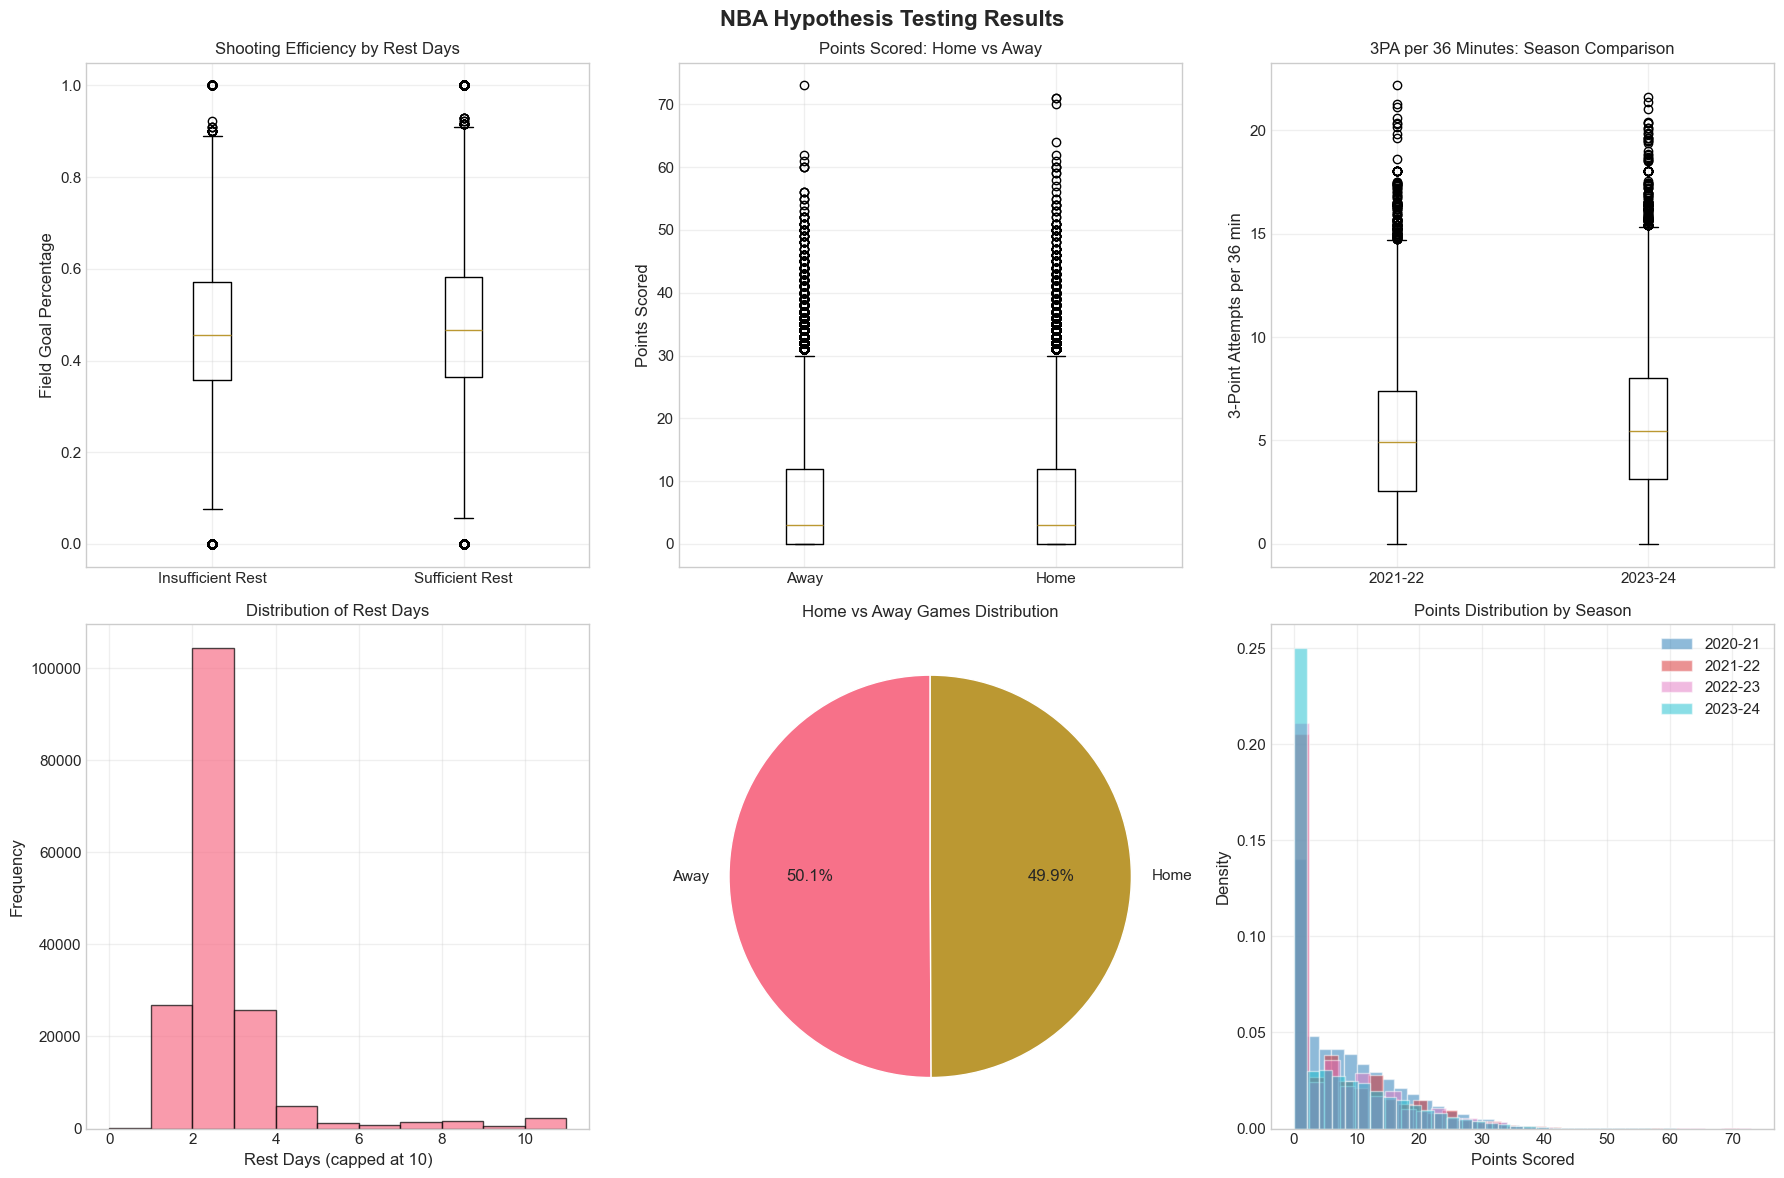

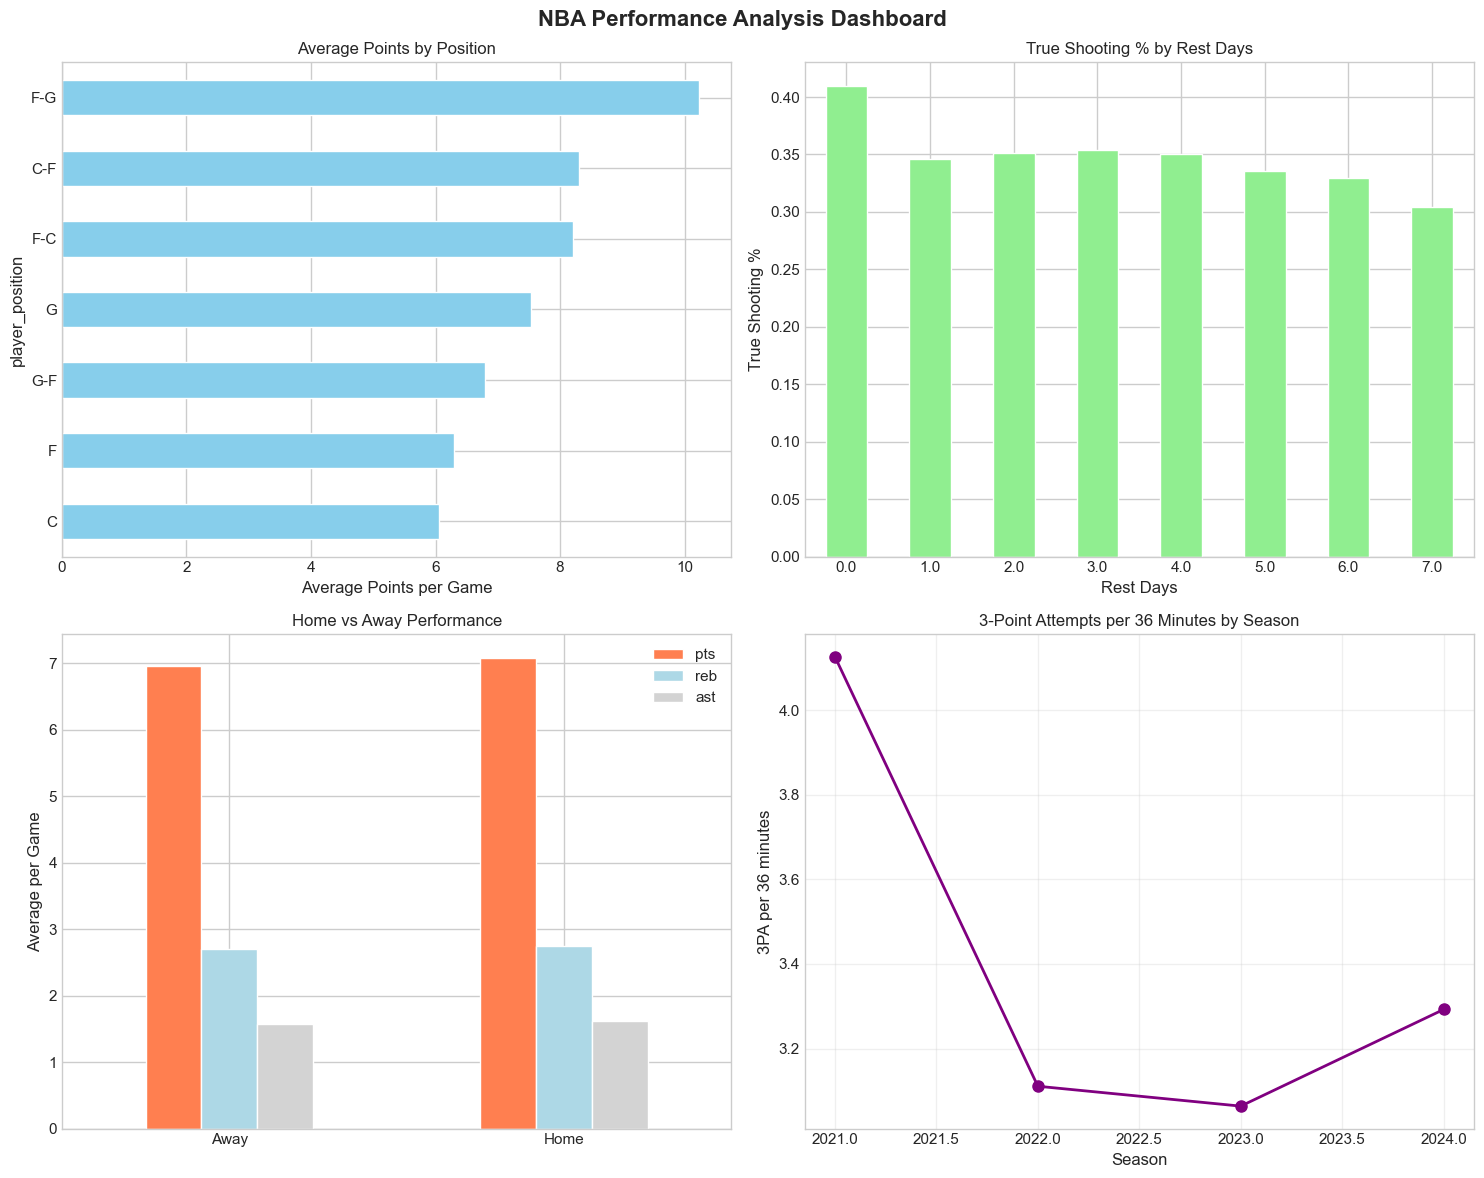

In [10]:
# =============================================================================
# Comprehensive Visualizations
# =============================================================================

# Create visualization plots
hypothesis_tester.create_visualization_plots(figsize=(18, 12))

# Create additional analysis visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('NBA Performance Analysis Dashboard', fontsize=16, fontweight='bold')

# Performance by Position
if 'player_position' in df_engineered.columns:
    position_performance = df_engineered.groupby('player_position')['pts'].mean().sort_values(ascending=True)
    position_performance.plot(kind='barh', ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Average Points by Position')
    axes[0, 0].set_xlabel('Average Points per Game')

# Rest Days Impact on Efficiency
if all(col in df_engineered.columns for col in ['rest_days', 'true_shooting_pct']):
    rest_efficiency = df_engineered.groupby('rest_days')['true_shooting_pct'].mean()
    rest_efficiency[rest_efficiency.index <= 7].plot(kind='bar', ax=axes[0, 1], color='lightgreen')
    axes[0, 1].set_title('True Shooting % by Rest Days')
    axes[0, 1].set_xlabel('Rest Days')
    axes[0, 1].set_ylabel('True Shooting %')
    axes[0, 1].tick_params(axis='x', rotation=0)

# Home vs Away Performance
if 'is_home_game' in df_engineered.columns:
    home_away = df_engineered.groupby('is_home_game')[['pts', 'reb', 'ast']].mean()
    home_away.index = ['Away', 'Home']
    home_away.plot(kind='bar', ax=axes[1, 0], color=['coral', 'lightblue', 'lightgray'])
    axes[1, 0].set_title('Home vs Away Performance')
    axes[1, 0].set_ylabel('Average per Game')
    axes[1, 0].tick_params(axis='x', rotation=0)
    axes[1, 0].legend()

# Season Evolution of 3-Point Attempts
if 'fg3a_per_36min' in df_engineered.columns:
    season_3pa = df_engineered.groupby('game_season')['fg3a_per_36min'].mean()
    season_3pa.plot(kind='line', ax=axes[1, 1], marker='o', linewidth=2, markersize=8, color='purple')
    axes[1, 1].set_title('3-Point Attempts per 36 Minutes by Season')
    axes[1, 1].set_xlabel('Season')
    axes[1, 1].set_ylabel('3PA per 36 minutes')
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../outputs/visuals/reporting_results/hypothesis_testing_dashboard.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [11]:
# =============================================================================
# Performance Insights and Summary
# =============================================================================

# Top performers
top_scorers = df_engineered.groupby('player_id')['pts'].mean().nlargest(5)
print(f"\nTop 5 Average Scorers:")
for i, (player_id, avg_pts) in enumerate(top_scorers.items(), 1):
    player_name = df_engineered[df_engineered['player_id'] == player_id]['player_full_name'].iloc[0] if 'player_full_name' in df_engineered.columns else f"Player {player_id}"
    print(f"   {i}. {player_name}: {avg_pts:.1f} PPG")

# Performance milestones
if 'double_double' in df_engineered.columns:
    print(f"\nPerformance Milestones:")
    dd_rate = df_engineered['double_double'].mean() * 100
    print(f"   Double-double rate: {dd_rate:.1f}%")
    
if 'triple_double' in df_engineered.columns:
    td_rate = df_engineered['triple_double'].mean() * 100
    print(f"   Triple-double rate: {td_rate:.2f}%")

# Efficiency insights
if 'true_shooting_pct' in df_engineered.columns:
    avg_ts = df_engineered['true_shooting_pct'].mean()
    print(f"\nAverage True Shooting %: {avg_ts:.1%}")

# Rest day insights
if 'sufficient_rest' in df_engineered.columns:
    rest_performance = df_engineered.groupby('sufficient_rest')[['pts', 'fg_pct']].mean()
    print(f"\nRest Day Impact:")
    print(f"   Well-rested games: {rest_performance.loc[True, 'pts']:.1f} PPG, {rest_performance.loc[True, 'fg_pct']:.1%} FG%")
    print(f"   Less rest games: {rest_performance.loc[False, 'pts']:.1f} PPG, {rest_performance.loc[False, 'fg_pct']:.1%} FG%")

# Home court advantage
if 'is_home_game' in df_engineered.columns:
    home_advantage = df_engineered.groupby('is_home_game')['pts'].mean()
    advantage = home_advantage[True] - home_advantage[False]
    print(f"\nHome Court Advantage: +{advantage:.1f} points per game")


Top 5 Average Scorers:
   1. Shai Gilgeous-Alexander: 27.5 PPG
   2. Giannis Antetokounmpo: 25.8 PPG
   3. Jayson Tatum: 25.4 PPG
   4. Luka Doncic: 25.3 PPG
   5. Nikola Jokic: 25.0 PPG

Performance Milestones:
   Double-double rate: 5.6%
   Triple-double rate: 0.34%

Average True Shooting %: 35.0%

Rest Day Impact:
   Well-rested games: 7.0 PPG, 28.7% FG%
   Less rest games: 6.9 PPG, 28.2% FG%

Home Court Advantage: +0.1 points per game


In [12]:
# =============================================================================
# Data Export
# =============================================================================

final_output_path = "../data/processed/final_engineered_nba_data.parquet"
df_engineered.to_parquet(final_output_path, index=False)
print(f"Final dataset saved to: {final_output_path}")

Final dataset saved to: ../data/processed/final_engineered_nba_data.parquet


In [13]:
df_raw.columns ## raw data columns

Index(['id', 'min', 'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm',
       'fta', 'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'turnover',
       'pf', 'pts', 'player_id', 'player_first_name', 'player_last_name',
       'player_position', 'player_team_id', 'team_id', 'team_abbreviation',
       'team_full_name', 'game_id', 'game_date', 'game_season',
       'game_home_team_id', 'game_visitor_team_id', 'game_postseason'],
      dtype='object')

In [14]:
df_engineered.columns ## processed data columns after current feature_engineer.py is applied

Index(['id', 'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta',
       'ft_pct',
       ...
       'high_scoring_game', 'efficient_game', 'minutes_played_x_rest_days',
       'minutes_played_x_is_home_game', 'rest_days_x_is_home_game',
       'sufficient_rest_x_minutes_played', 'is_home_game_x_is_weekend',
       'rest_days_x_month', 'minutes_played_x_day_of_week',
       'is_weekend_x_rest_days'],
      dtype='object', length=113)

In [15]:
# Print each column on its own line
for i, col in enumerate(df_engineered.columns):
    print(f"{i+1:3d}: {col}")

  1: id
  2: fgm
  3: fga
  4: fg_pct
  5: fg3m
  6: fg3a
  7: fg3_pct
  8: ftm
  9: fta
 10: ft_pct
 11: oreb
 12: dreb
 13: reb
 14: ast
 15: stl
 16: blk
 17: turnover
 18: pf
 19: pts
 20: player_id
 21: player_first_name
 22: player_last_name
 23: player_position
 24: player_team_id
 25: team_id
 26: team_abbreviation
 27: team_full_name
 28: game_id
 29: game_date
 30: game_season
 31: game_home_team_id
 32: game_visitor_team_id
 33: game_postseason
 34: minutes_played
 35: pts_outlier_flag
 36: reb_outlier_flag
 37: ast_outlier_flag
 38: minutes_played_outlier_flag
 39: fga_outlier_flag
 40: fg3a_outlier_flag
 41: player_position_standardized
 42: player_full_name
 43: rest_days
 44: rest_days_category
 45: sufficient_rest
 46: is_back_to_back
 47: is_first_game
 48: true_shooting_pct
 49: effective_fg_pct
 50: perfect_ft_game
 51: good_shooting_game
 52: pts_per_min
 53: pts_per_36min
 54: reb_per_min
 55: reb_per_36min
 56: ast_per_min
 57: ast_per_36min
 58: stl_per_min
 59: 